# Consumer complaints topic extraction using Latent diriclect allocation (LDA) and Latent semantic analysis (LSA)
LSA is a method of analyzing text data using principal component analysis. LDA is a probabilistic approach, utilizing the Dirichlet distribution. Over-fitting is less likely with LDA since it uses priors.

Additionally, both documents and words are represented by orthogonal vectors. LDA is concerned with independent topics, while LSA is concerned with orthogonal representations.

Lastly, LDA requires a minimum number of topics or components. K is selected as the most effective method for capturing the majority of variations in the data.

# Comcast consumer complaint dataset

This dataset was obtained from kaggle and made readily available to all by charlie.H. This data set contains 2 CSV files.
1. comcast_consumeraffairs_complaints.csv
2. comcast_fcc_complaints_2015.csv

The first data set however is more beneficial for sentiment analysis. We will be working with the second dataset today comcast_fcc_complaints_2015.csv. it contains several columns including one with verbatim which we will use for topic extraction.

# Initializing packages and exploring the dataset

In [17]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')



df = pd.read_csv('comcast_fcc_complaints_2015.csv')
display(df)

[nltk_data] Downloading package wordnet to C:\Users\Kumarappan
[nltk_data]     M\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Kumarappan
[nltk_data]     M\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Ticket #,Customer Complaint,Date,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone,Description
0,250635,Comcast Cable Internet Speeds,4/22/2015,3:53:50 PM,Internet,Abingdon,Maryland,21009,Closed,No,I have been contacting Comcast Internet Techni...
1,223441,Payment disappear - service got disconnected,4/8/2015,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No,Back in January 2015 I made 2 payments: One fo...
2,242732,Speed and Service,4/18/2015,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes,Our home is located at in Acworth Georgia 3010...
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,5/7/2015,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes,Comcast in the Atlanta area has just put into ...
4,307175,Comcast not working and no service to boot,5/26/2015,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No,I have been a customer of Comcast of some sort...
...,...,...,...,...,...,...,...,...,...,...,...
2220,213550,Service Availability,4/2/2015,9:13:18 AM,Internet,Youngstown,Florida,32466,Closed,No,I am a deaf guy. I have asked ATT or Comcast t...
2221,318775,Comcast Monthly Billing for Returned Modem,6/2/2015,1:24:39 PM,Internet,Ypsilanti,Michigan,48197,Solved,No,We purchased our own modem and returned the Co...
2222,331188,complaint about comcast,6/9/2015,5:28:41 PM,Internet,Ypsilanti,Michigan,48197,Solved,No,i had an agreement with comcast agent 1 year f...
2223,360489,Extremely unsatisfied Comcast customer,6/23/2015,11:13:30 PM,Internet,Ypsilanti,Michigan,48197,Solved,No,A few months ago I was forced to finally call ...


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Ticket #                     2225 non-null   object
 1   Customer Complaint           2225 non-null   object
 2   Date                         2225 non-null   object
 3   Time                         2225 non-null   object
 4   Received Via                 2225 non-null   object
 5   City                         2225 non-null   object
 6   State                        2225 non-null   object
 7   Zip code                     2225 non-null   int64 
 8   Status                       2225 non-null   object
 9   Filing on Behalf of Someone  2225 non-null   object
 10  Description                  2225 non-null   object
dtypes: int64(1), object(10)
memory usage: 191.3+ KB


### Complaint Categories

The column "customer Complaints" contains the different categories each complaint falls under. On further analysis, we find that there are 1842 categories. This probably is not the case, most customers file their issues under wrong categories by using LDA and LSA we can effectively classify these complaints into n number of topics of our choice.

In [19]:
df['Customer Complaint'].value_counts()

Comcast                                          83
Comcast Internet                                 18
Comcast Data Cap                                 17
comcast                                          13
Comcast Data Caps                                11
                                                 ..
Improper Billing and non resolution of issues     1
Deceptive trade                                   1
intermittent internet                             1
Internet Speed on Wireless Connection             1
Comcast, Ypsilanti MI Internet Speed              1
Name: Customer Complaint, Length: 1842, dtype: int64

# Data Pre-Processing

#### 1. Tokenization
#### 2. lemmatization
#### 3. stemming

In [20]:
def lemma_stem(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))


def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemma_stem(token))

    return result

### Regular Split Vs Stemmer Difference

In [21]:
print("Stemmed original document using a regular split(): ")
words = []
for word in df['Customer Complaint'].str.split(' '):
    words.append(word)
print(words[:5])

Stemmed original document using a regular split(): 
[['Comcast', 'Cable', 'Internet', 'Speeds'], ['Payment', 'disappear', '-', 'service', 'got', 'disconnected'], ['Speed', 'and', 'Service'], ['Comcast', 'Imposed', 'a', 'New', 'Usage', 'Cap', 'of', '300GB', 'that', 'punishes', 'streaming.'], ['Comcast', 'not', 'working', 'and', 'no', 'service', 'to', 'boot']]


In [22]:
stemmer = SnowballStemmer("english")
print(df['Customer Complaint'].fillna('').astype(str).map(preprocess))

0               [comcast, cabl, internet, speed]
1       [payment, disappear, servic, disconnect]
2                                [speed, servic]
3         [comcast, impos, usag, punish, stream]
4                  [comcast, work, servic, boot]
                          ...                   
2220                             [servic, avail]
2221       [comcast, month, bill, return, modem]
2222                        [complaint, comcast]
2223        [extrem, unsatisfi, comcast, custom]
2224       [comcast, ypsilanti, internet, speed]
Name: Customer Complaint, Length: 2225, dtype: object


In [23]:
processed_docs = []

for doc in df['Customer Complaint'].fillna('').astype(str):
    processed_docs.append(preprocess(doc))

# For LSA
df['Text (Clean)'] = df['Customer Complaint'].apply(lambda x: preprocess(x))

## Bag of Words ( BoW )


First we create a dictionary of the number of times each word occurs across the corpus by using the gensim package's dictionary function. This will be used as a parameter 'ID2' for our LDA model later.

In [24]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

# We now filter words that occur less than 5 times and those occurring more than half the time.
dictionary.filter_extremes(no_below=5, no_above=0.5)

0 cabl
1 comcast
2 internet
3 speed
4 disappear
5 disconnect
6 payment
7 servic
8 impos
9 punish
10 stream


### Gensim doc2bow

Each document in the corpus is assigned a BoW model by Doc2bow. An index of the number of times each word appears in a document is produced as a result.

In [25]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## Latent Dirichlect Allocation (LDA)

In [26]:
lda_model =  gensim.models.LdaMulticore(bow_corpus,
                                        num_topics = 6,
                                        id2word = dictionary,
                                        passes = 10,
                                        workers = 2)

In [27]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.153*"issu" + 0.124*"servic" + 0.118*"xfiniti" + 0.050*"bill" + 0.047*"advertis" + 0.031*"provid" + 0.028*"cancel" + 0.027*"account" + 0.027*"custom" + 0.027*"switch"


Topic: 1 
Words: 0.374*"bill" + 0.114*"practic" + 0.064*"unfair" + 0.045*"charg" + 0.029*"modem" + 0.029*"fraudul" + 0.021*"decept" + 0.018*"equip" + 0.017*"rental" + 0.017*"failur"


Topic: 2 
Words: 0.324*"internet" + 0.164*"speed" + 0.061*"throttl" + 0.060*"complaint" + 0.049*"slow" + 0.048*"cabl" + 0.030*"connect" + 0.028*"problem" + 0.021*"pay" + 0.021*"high"


Topic: 3 
Words: 0.326*"data" + 0.122*"cap" + 0.070*"usag" + 0.048*"month" + 0.038*"charg" + 0.034*"lie" + 0.033*"limit" + 0.028*"overag" + 0.027*"servic" + 0.025*"busi"


Topic: 4 
Words: 0.130*"price" + 0.118*"charg" + 0.046*"servic" + 0.042*"contract" + 0.038*"refus" + 0.028*"increas" + 0.026*"fee" + 0.024*"instal" + 0.023*"credit" + 0.021*"unfair"


Topic: 5 
Words: 0.333*"servic" + 0.137*"internet" + 0.071*"custom" + 0.041*"poor" + 0.0

#### The model has produced five outputs. Using these five topics, it is possible to categorize all the words in the corpus. The LDA model, however, does not provide us with the topic names. we infer that from the results or we could use print_topics from pprint.

#### Manual Topic Classification Based on the above output

1. Concern
2. High-speed
3. Disappointing
4. Surcharge
5. Deceit
6. Bandwidth

#### Dominant Topics

As i have mentioned before each document can have multiple topics, however, certain topics have more weight than others in the document in other words they make up the document. We will now see how to identify those topics and shows their score for each docuemnt.

In [28]:
def format_topics_sentences(ldamodel=None, corpus=bow_corpus, texts=processed_docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list

        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=processed_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

C:\Users\Kumarappan M\AppData\Local\Temp\ipykernel_19572\1440746600.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Kumarappan M\AppData\Local\Temp\ipykernel_19572\1440746600.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.7916,"internet, speed, throttl, complaint, slow, cab...","[comcast, cabl, internet, speed]"
1,1,5,0.6260,"servic, internet, custom, poor, phone, monopol...","[payment, disappear, servic, disconnect]"
2,2,2,0.3901,"internet, speed, throttl, complaint, slow, cab...","[speed, servic]"
3,3,3,0.3893,"data, cap, usag, month, charg, lie, limit, ove...","[comcast, impos, usag, punish, stream]"
4,4,5,0.7216,"servic, internet, custom, poor, phone, monopol...","[comcast, work, servic, boot]"
5,5,3,0.8605,"data, cap, usag, month, charg, lie, limit, ove...","[charg, arbitrari, data, limit, overag, fee]"
6,6,3,0.4795,"data, cap, usag, month, charg, lie, limit, ove...","[throttl, servic, unreason, data, cap]"
7,7,0,0.4967,"issu, servic, xfiniti, bill, advertis, provid,...","[comcast, refus, help, troubleshoot, correct, ..."
8,8,5,0.5833,"servic, internet, custom, poor, phone, monopol...","[comcast, extend, outag]"
9,9,4,0.4676,"price, charg, servic, contract, refus, increas...","[comcast, rais, price, avail]"


#### Word count of Dominant Topics

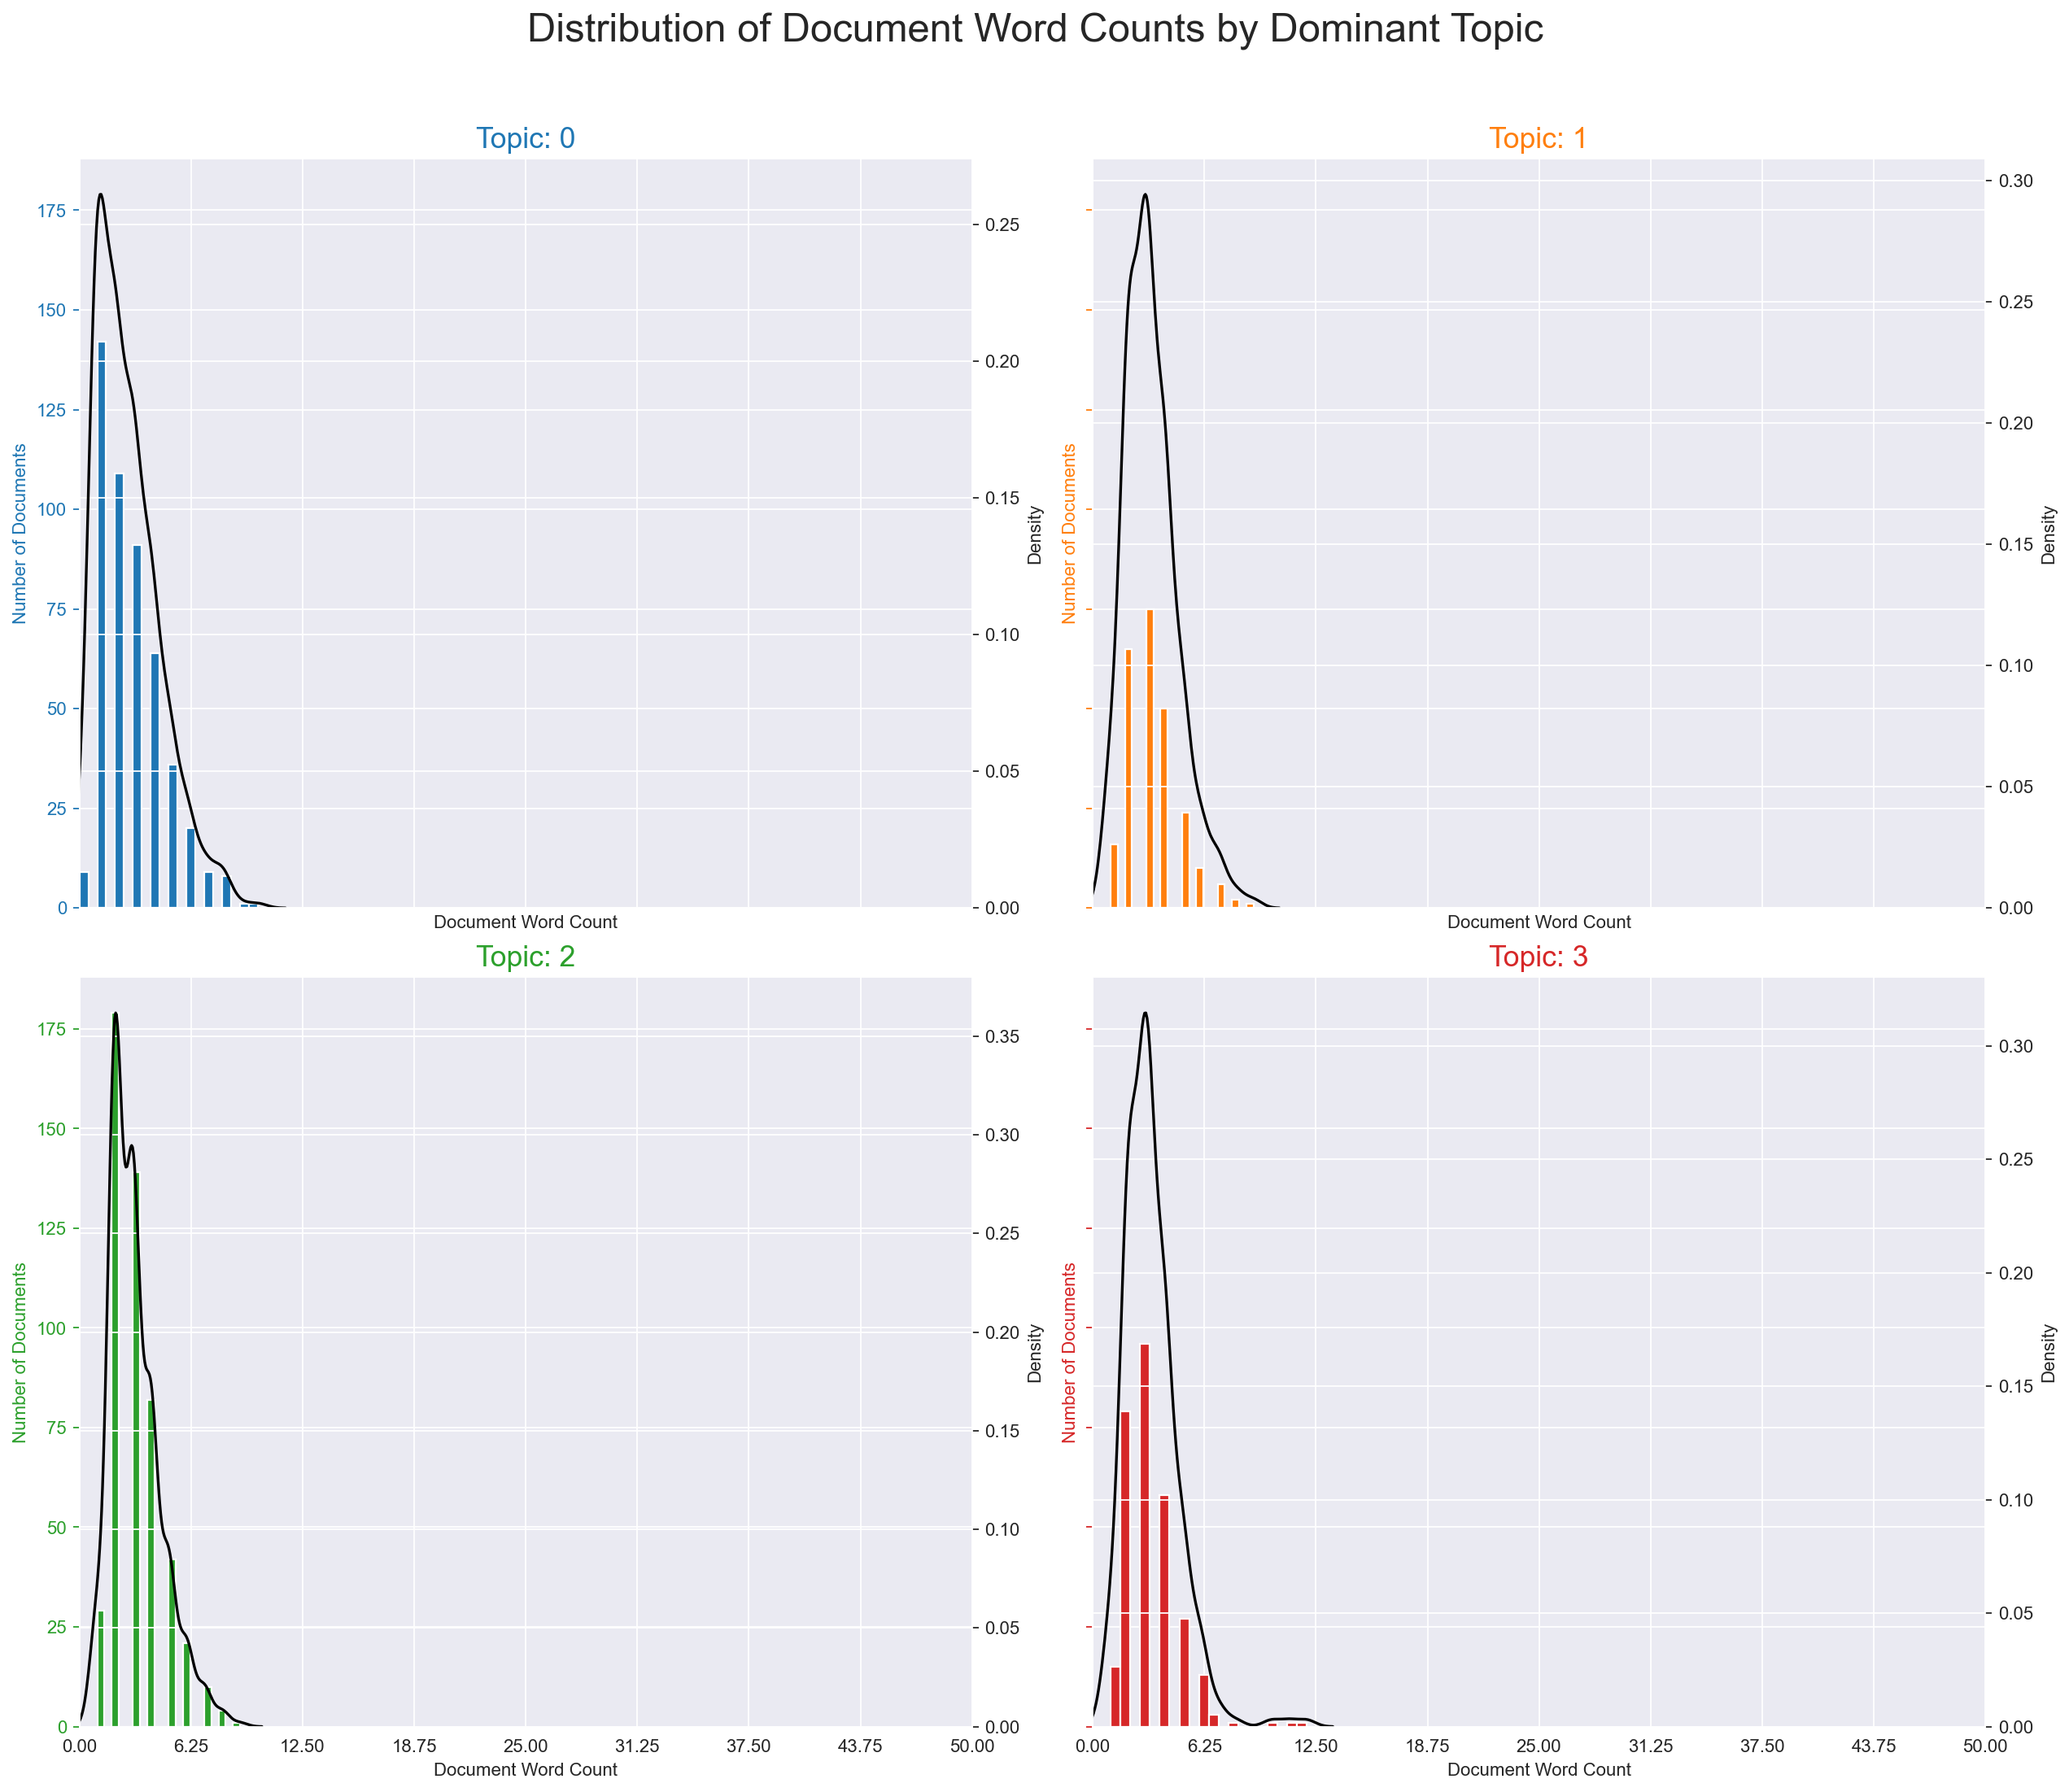

In [29]:
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 20, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 20), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,50,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

#### Evaluation

There are two methods that could be leveraged to evaluate a LDA model, coherence and perplexity. Uncertainty is measured by perplexity, so the lower the perplexity, the more accurate the model. This is what we will be using today. As you can see the model performed well with a score of -4.58901


In [30]:
print('Perplexity Metric: ', lda_model.log_perplexity(bow_corpus))

Perplexity Metric:  -4.478042482962956


## Latent Semantic Analysis ( LSA )

In [31]:
# Calculate the coherence score when you have a different number of topics
for i in range(2,11):
    lsi = LsiModel(bow_corpus, num_topics=i, id2word=dictionary)
    coherence_model = CoherenceModel(model=lsi, texts=df['Text (Clean)'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} Topics: {}'.format(i, coherence_score))

Coherence score with 2 Topics: 0.47971731146108576
Coherence score with 3 Topics: 0.5115648838246382
Coherence score with 4 Topics: 0.531754398730208
Coherence score with 5 Topics: 0.5124521862003294
Coherence score with 6 Topics: 0.5055824117033784
Coherence score with 7 Topics: 0.5176241275525864
Coherence score with 8 Topics: 0.5023886490556254
Coherence score with 9 Topics: 0.510940295298528
Coherence score with 10 Topics: 0.5061120453145798


#### When performing SVD, we will extract the topics with the highest coherence score. The strongest associations each topic has with 5 words are selected here.

In [35]:
# Extract 2 topics from the bag of words using SVD and the LsiModel
lsi = LsiModel(bow_corpus, num_topics=4, id2word=dictionary)

In [36]:
for topic_num, words in lsi.print_topics(num_words=5):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: -0.677*"servic" + -0.645*"internet" + -0.197*"bill" + -0.164*"speed" + -0.122*"custom".
Words in 1: -0.675*"internet" + 0.607*"servic" + -0.252*"speed" + 0.239*"bill" + 0.150*"custom".
Words in 2: -0.870*"bill" + 0.322*"servic" + -0.228*"practic" + -0.188*"issu" + -0.153*"unfair".
Words in 3: 0.886*"data" + 0.376*"cap" + 0.169*"usag" + 0.108*"charg" + -0.106*"bill".


#### We can now see how the model scores each word based on the topic assigned to it. Documents can contain a number of topics, but some topics are closely related. This helps us determine the topic a document is associated with.

In [37]:
corpus_lsi = lsi[bow_corpus]
score1 = []
score2 = []
for doc in corpus_lsi:
    score1.append(doc)
    score2.append(doc)

# create data frame that shows scores assigned for both topics for each review
df_topic = pd.DataFrame()
df_topic['Text'] = df['Text (Clean)']
df_topic['Topic 0 score'] = score1
df_topic['Topic 1 score'] = score2
from operator import itemgetter
df_topic['Topic']= df_topic[['Topic 0 score', 'Topic 1 score']].apply(lambda x: x.max(), axis=1)
df_topic.head(1)

,Text,Topic 0 score,Topic 1 score,Topic
0,"[comcast, cabl, internet, speed]","[(0, -0.8460348908008445), (1, -0.963516760780...","[(0, -0.8460348908008445), (1, -0.963516760780...","[(0, -0.8460348908008445), (1, -0.963516760780..."


The above is just an example with 2 topics, but it shows you the score related to each topic of a document allowing us to determine which topic best resembles the document.